# **Khushdev Pandit**
# **Roll no: 2020211** 
# *Assignment Question-1*

In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

# **Q1 Part-1**

## **1(a)** *Download train 32x32.mat. Use 20% of the training dataset for validation and 10% for testing Initialize Weights & Biases*

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import scipy.io
path_data = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Assignments/Assignment-1/Q1/train_32x32.mat"
mat = scipy.io.loadmat(path_data)

print('Keys:', mat.keys())
for key in mat.keys():
    if key != 'X' and key != 'y':
        print(key,': ', mat[key])

lenx = len(mat['X'][0][0][0])
leny = len(mat['y'])
print('Num of images:',(lenx, leny))

Keys: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
__header__ :  b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011'
__version__ :  1.0
__globals__ :  []
Num of images: (73257, 73257)


In [4]:
print(mat['X'][:,:,:,0].shape)
print(mat['y'][0])

(32, 32, 3)
[1]


Class/Labels:  [ 1  2  3  4  5  6  7  8  9 10]
Labels count distribution


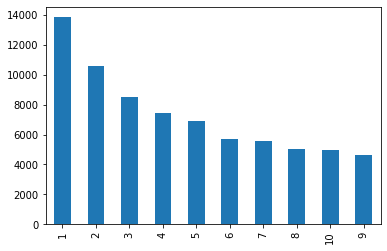

In [5]:
print("Class/Labels: ", np.unique(mat['y']))
print("Labels count distribution")
pd.Series(mat['y'][:,0]).value_counts().plot(kind='bar');

Class/Labels:  [0 1 2 3 4 5 6 7 8 9]
Labels count distribution


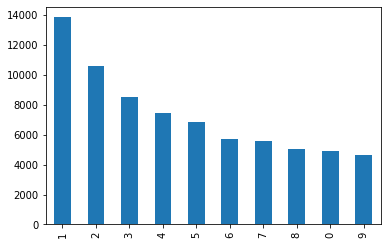

In [6]:
indices_10 = (mat['y'] == 10)
mat['y'][indices_10] = 0

print("Class/Labels: ", np.unique(mat['y']))
print("Labels count distribution")
pd.Series(mat['y'][:,0]).value_counts().plot(kind='bar');

In [7]:
train_size = int(lenx*0.70)
val_size = int(lenx*0.20)
test_size = int(lenx*0.10)
print((train_size, val_size, test_size))

(51279, 14651, 7325)


In [8]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=699d30d6dd7500c48465805fadf07970ee52e54131e08a6331a67790aa593e71
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [9]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## **1(b)** *Create custom data loaders for all the splits (train, val and test) using PyTorch.*

(32, 32, 3) 8


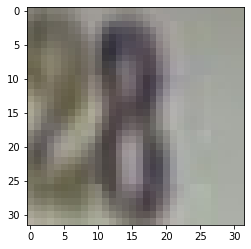

In [11]:
class SVHNDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data['X'][0][0][0])
    
    def __getitem__(self, idx, plot=False):
        img_data = self.data['X'][:,:,:,idx]
        img_label = self.data['y'][idx]
        # img_data = torch.from_numpy(img_data) 
        # img_label = torch.tensor([img_label])
        if (self.transform is not None) and (plot==False):
            img_data = self.transform(img_data)
        return img_data, img_label[0]

dataset = SVHNDataset(mat)
img, label = dataset.__getitem__(13)
print(img.shape, label)
plt.imshow(img);

In [ ]:
g = torch.Generator()
g.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Creating dataset
dataset = SVHNDataset(data=mat, transform=transform)
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Train, Validation and Test Split
test_index = indices[:test_size]
train_index = indices[test_size : test_size+train_size]
val_index = indices[-val_size:]

# SubsetRandomSampler for train, validation and test
train_sampler = SubsetRandomSampler(train_index, generator=g)
val_sampler = SubsetRandomSampler(val_index, generator=g)
test_sampler = SubsetRandomSampler(test_index, generator=g)

In [ ]:
batch_size = 1

# Custom data loaders for all the splits (train, val and test)
trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size,num_workers=2)
valloader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size,num_workers=2)
testloader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size,num_workers=2)

print(len(trainloader), len(valloader), len(testloader))

51279 14651 7325


## **1(c)** *Visualize the data distribution across class labels for training and validation sets.*

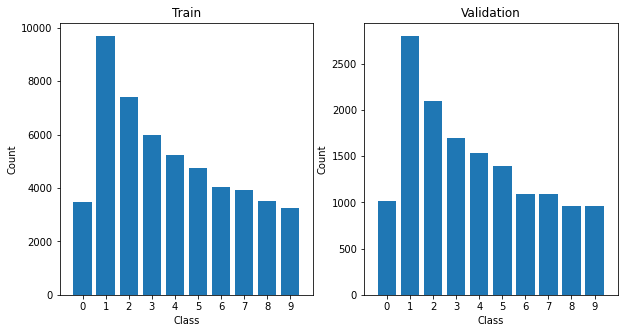

[3481, 9694, 7421, 5988, 5232, 4747, 4022, 3939, 3497, 3258]
[1015, 2802, 2098, 1694, 1537, 1398, 1096, 1091, 964, 956]


In [ ]:
import seaborn as sns

def class_distribution(data):
    classes = [0]*10
    for i in range(len(data)):
        img, label = data.dataset.__getitem__(i, plot=True)
        classes[label] += 1
    return classes

train_classes = class_distribution(trainloader)
val_classes = class_distribution(valloader)

# plot the class distribution in subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(range(0,10), train_classes)
axes[0].set_title('Train')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(0,10))
axes[0].set_xlim(-1, 10)
axes[1].bar(range(0,10), val_classes)
axes[1].set_title('Validation')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class')
axes[1].set_xticks(range(0,10))
axes[1].set_xlim(-1, 10)
plt.show()

print(train_classes)
print(val_classes)

In [ ]:
Part-1 Done

# **Q1 Part-2** **Training a CNN from scratch**

## **Q2 (a)** *Create a CNN architecture with 2 Convolution Layers having a kernel size of 3×3 and padding of 1. Use 32 feature maps for the first layer and 64 for the second. Finally add classification head to the conv layers. Use ReLU activation functions wherever applicable.*

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First Convolution Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        # Second Convolution Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()        
        # Classification Head
        self.fc = nn.Linear(in_features=64*32*32, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        # x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = self.conv2(x)
        x = self.relu2(x)        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## **Q2 (b)** *Train the model using the Cross-Entropy Loss. Use wandb to log the training and validation losses and accuracies.*

In [ ]:
# Model
model = CNN()

# Hyperparameters
lr=0.001
epochs=10
wd = 1e-3
batch_size = 64

# Custom data loaders for all the splits (train, val and test)
trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size,num_workers=2)
valloader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size,num_workers=2)
testloader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size,num_workers=2)
print(len(trainloader), len(valloader), len(testloader))

802 229 115


In [ ]:
wandb.init(entity="cv_assignment", project="Assignment-1",name="Q1-Part2")
wandb.config = {"learning_rate": lr , "epochs": epochs, "batch_size": batch_size}  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
epochs = 4

# Train the model
for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    train_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    print("Training Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(trainloader), train_accuracy))

    # Evaluate the model on validation set
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(val_loss/ len(valloader), val_accuracy))

    # Log the loss and accuracy to W&B
    wandb.log({'training_loss': train_loss / len(trainloader), 'validation_loss': val_loss / len(valloader),
               'training_accuracy': train_accuracy, 'validation_accuracy': val_accuracy})

print('Finished Training')

Epoch:  1
Training Loss: 0.9903,  Training Accuracy: 68.9717
Validation Loss: 0.6548,  Validation Accuracy: 80.9979
Epoch:  2
Training Loss: 0.5929,  Training Accuracy: 82.8331
Validation Loss: 0.6037,  Validation Accuracy: 82.3015
Epoch:  3
Training Loss: 0.5305,  Training Accuracy: 84.4712
Validation Loss: 0.5805,  Validation Accuracy: 82.7793
Epoch:  4
Training Loss: 0.4899,  Training Accuracy: 85.7213
Validation Loss: 0.5508,  Validation Accuracy: 83.9943
Finished Training


## **Q2 (c)** *Report the Accuracy and F1-Score on the test set. Also, log the confusion matrix using wandb.*

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate the model on test set
correct, total = 0, 0
x_test_img = []
y_test_true = []
y_test_pred = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        x_test_img.extend(inputs.numpy().tolist())
        y_test_true.extend(labels.numpy().tolist())
        y_test_pred.extend(predicted.numpy().tolist())
test_accuracy = 100 * correct / total
print("Test set accuracy: {:.2f}%".format(test_accuracy))

# Compute the F1-score on testing set
f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("Test set F1-score: {:.4f}".format(f1))

# Compute the confusion matrix for the Predictions
cm = confusion_matrix(y_test_true, y_test_pred)

# Logging the confusion matrix to W&B
wandb.log({'confusion_matrix': wandb.Image(cm, caption='Confusion Matrix')})

Test set accuracy: 84.45%
Test set F1-score: 0.8316


In [ ]:
# ✨ W&B: Save Model
torch.save(model.state_dict(),"cnn_q1_b.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('cnn_q1_b.pth')
wandb.log_artifact(artifact)
wandb.finish()

training_accuracy,▁▇▇█
training_loss,█▂▂▁
validation_accuracy,▁▄▅█
validation_loss,█▅▃▁
training_accuracy,85.72125
training_loss,0.48988
validation_accuracy,83.99427
validation_loss,0.55084


## **Q2 (d)** *For each class in the test set, visualize any 3 images that were misclassified along with the predicted class label. Analyze why the model could possibly be failing in these cases. Is this due to the fact that image looks much similar to the predicted class than the actual ground truth or something else?*

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Visualization for Class:  0
Visualization for Class:  1
Visualization for Class:  2
Visualization for Class:  3
Visualization for Class:  4
Visualization for Class:  5
Visualization for Class:  6
Visualization for Class:  7
Visualization for Class:  8
Visualization for Class:  9


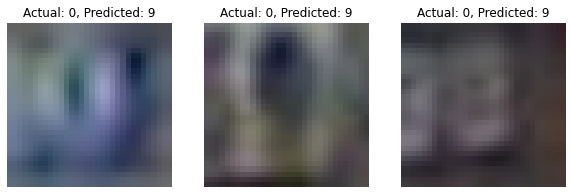

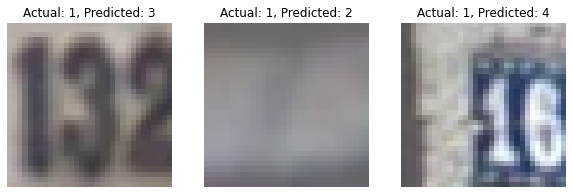

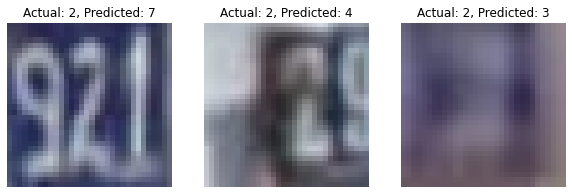

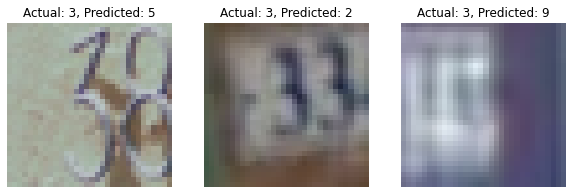

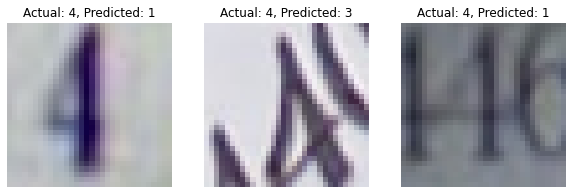

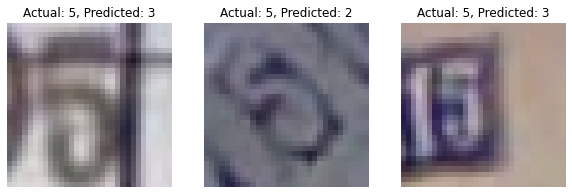

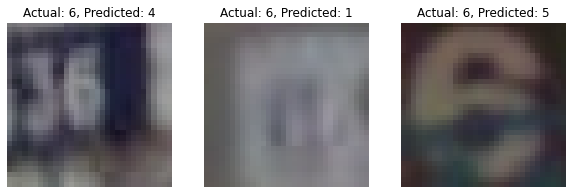

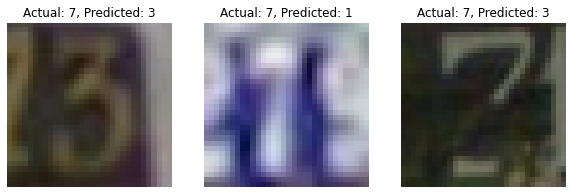

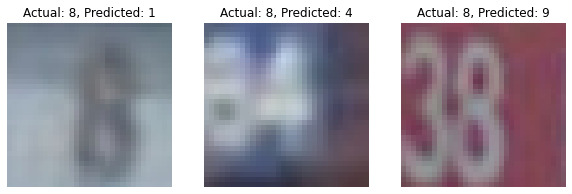

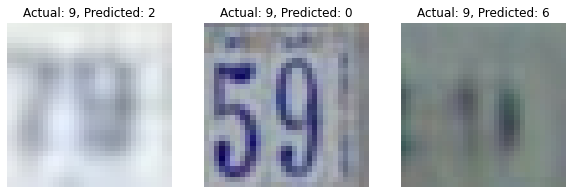

In [ ]:
x_test_img = np.array(x_test_img)
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)

for out_class in range(10):
    print('Visualization for Class: ', out_class)
    class_ind = np.where(y_test_true == out_class)
    missclassfication_ind = np.where(y_test_pred[class_ind] != out_class)
    np.random.shuffle(missclassfication_ind)
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    start = 4
    for i in range(start,start+3):
        # print(np.max(x_test_img[class_ind][missclassfication_ind][i]))
        img = x_test_img[class_ind][missclassfication_ind][i] / 2 + 0.5
        axes[i-start].imshow(img.transpose(1,2,0))
        axes[i-start].set_title('Actual: ' + str(out_class) + ', Predicted: ' + str(y_test_pred[class_ind][missclassfication_ind][i]))
        axes[i-start].axis('off')

In [ ]:
Part-2 Done

# **Q1 Part-3**  **Fine-tuning a pretrained model**

## **Q3 (a)** *Train another classification model with a fine-tuned Resnet-18 (pre-trained on ImageNet) architecture using the same strategy used in Question1.2.(b) and again use wandb for logging the loss and accuracy.*

In [12]:
# Creating dataset
dataset = SVHNDataset(data=mat, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
))
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Train, Validation and Test Split
test_index = indices[:test_size]
train_index = indices[test_size : test_size+train_size]
val_index = indices[-val_size:]

# SubsetRandomSampler for train, validation and test
g = torch.Generator()
g.manual_seed(42)
train_sampler = SubsetRandomSampler(train_index, generator=g)
val_sampler = SubsetRandomSampler(val_index, generator=g)
test_sampler = SubsetRandomSampler(test_index, generator=g)

# Custom data loaders for all the splits (train, val and test)
batch_size = 64
trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size,num_workers=2)
valloader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size,num_workers=2)
testloader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size,num_workers=2)
print(len(trainloader), len(valloader), len(testloader))

802 229 115


In [13]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze none of layers
for param in model.parameters():
    param.requires_grad = True
model.fc.requires_grad = True

# Replace the last fully connected layer with a new one with the desired number of classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Define the loss function and optimizer
lr = 0.001
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
wandb.init(entity="cv_assignment", project="Assignment-1",name="Q1-Part3")
wandb.config = {"learning_rate": lr , "epochs": epochs, "batch_size": batch_size}  

wandb: Currently logged in as: khushdev20211 (cv_assignment). Use `wandb login --relogin` to force relogin


In [ ]:
epochs = 4

# Train the model
for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    train_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    print("Training Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(trainloader), train_accuracy))

    # Evaluate the model on validation set
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(val_loss/ len(valloader), val_accuracy))

    # Log the loss and accuracy to W&B
    wandb.log({'training_loss': train_loss / len(trainloader), 'validation_loss': val_loss / len(valloader),
               'training_accuracy': train_accuracy, 'validation_accuracy': val_accuracy})

print('Finished Training')

Epoch:  1
Training Loss: 2.0700,  Training Accuracy: 27.0169
Validation Loss: 1.9768,  Validation Accuracy: 30.7965
Epoch:  2


## **Q3 (b)** *Report the Accuracy and F1-Score on the test set. Also, log the confusion matrix using wandb**

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate the model on test set
correct, total = 0, 0
x_test_img = []
y_test_true = []
y_test_pred = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        x_test_img.extend(inputs.numpy().tolist())
        y_test_true.extend(labels.numpy().tolist())
        y_test_pred.extend(predicted.numpy().tolist())
test_accuracy = 100 * correct / total
print("Test set accuracy: {:.2f}%".format(test_accuracy))

# Compute the F1-score on testing set
f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("Test set F1-score: {:.4f}".format(f1))

# Compute the confusion matrix for the Predictions
cm = confusion_matrix(y_test_true, y_test_pred)

# Logging the confusion matrix to W&B
wandb.log({'confusion_matrix': wandb.Image(cm, caption='Confusion Matrix')})

In [ ]:
# ✨ W&B: Save Model
torch.save(model.state_dict(),"cnn_q1_c.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('cnn_q1_c.pth')
wandb.log_artifact(artifact)
wandb.finish()